---
### Setup
* create a virtual environment
* run `pip install jupyter`
* Set Up Jupyter Kernel: `python -m ipykernel install --user --name=venv --display-name "data-analysis (venv)"
* Select this kernel

In [5]:
# Copy the data out files from the raspberry pi to the data folder with a shell command - SH: command not tested! 
!scp pi@lohast-IPAdresss:/root/presist/overlay/data/out /data/out

---
## Notebook for `berries` power analysis of all 

---
### Read Data: Read the Data from the `data` folder into the `data_dict` variable
* Reads the data from the `data/out` directory
* Saves the data to the `data_dict` variable

In [3]:
import os
import pandas as pd

SERVICES  = ['python-flask', 'go-gorilla', 'rust-actix'] # rust-actix
base_dir = 'data/out'
dir_out = 'plots/'
data_dict = {}

for service in SERVICES:
    
    service_dir = os.path.join(base_dir, service, 'berries')
    if not os.path.exists(service_dir):
        print(f"Directory does not exist: {service_dir}")
        continue
        
    # iterates of files in service_dir    
    for file_name in os.listdir(service_dir):
        file_path = os.path.join(service_dir, file_name)
            
        # Read the CSV files based on their naming convention
        if file_name.endswith(".csv"):
            if "power" in file_name:
                df_power = pd.read_csv(file_path)
                # Calculate timedelta and energy for each row
                df_power['timedelta'] = df_power['timestamp'].diff()
                df_power['energy'] = df_power['power'] * df_power['timedelta']
                # Fill NaN values with 0
                df_power['energy'] = df_power['energy'].fillna(0)
                df_power['timedelta'] = df_power['timedelta'].fillna(0)
                # Create cumulative energy column
                df_power['cumulative_energy'] = df_power['energy'].cumsum()
                # Create timedelta index
                df_power['timedelta_index'] = df_power['timestamp'].diff().fillna(0).cumsum()
                df_power.set_index('timedelta_index', inplace=True)
                df_power.sort_index(inplace=True)
                # Store DataFrame in data_dict
                data_dict[service] = df_power
            else:
                print("dataframe power does not exist")


In [4]:
# check applications in data_dict
print("applications in data_dict:")
print(data_dict.keys())
print("dataframe:")
data_dict['python-flask'].tail()

# Energy accumulated over time

applications in data_dict:
dict_keys(['python-flask', 'go-gorilla', 'rust-actix'])
dataframe:


,timestamp,power,current,voltage,timedelta,energy,cumulative_energy
timedelta_index,,,,,,,
41.76790,1.732294e+09,3.003609,0.600770,4.999601,0.00002,0.000060,128.490420
41.76792,1.732294e+09,3.015915,0.603164,5.000159,0.00002,0.000060,128.490481
41.76794,1.732294e+09,3.021709,0.604269,5.000604,0.00002,0.000061,128.490541
41.76796,1.732294e+09,3.021592,0.604304,5.000118,0.00002,0.000061,128.490602
41.76798,1.732294e+09,3.017463,0.603488,5.000036,0.00002,0.000060,128.490661


---
### Helper functions for data pipline sequential analysis

In [5]:
from datetime import datetime

# Helper functions for data pipline sequential analysis

def customize_boxplot(bplot, colors, tick_color, median_color):
    """
    Helper function to customize the appearance
    """
    # Customize the box colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set(color=color, linewidth=1.5)  # Set box outline color and line width
        patch.set(facecolor=color, alpha=0.8)  # Fill the box with the specified color

    # Customize the whiskers
    for whisker in bplot['whiskers']:
        whisker.set(color=tick_color, linewidth=1.5)  # Set whisker color and line width

    # Customize the caps
    for cap in bplot['caps']:
        cap.set(color=tick_color, linewidth=1.5)  # Set cap color and line width

    # Customize the medians
    for median in bplot['medians']:
        median.set(color=median_color, linewidth=1.5)  # Set median line color
        
        
def save_plot(fig, weact_service, plot_type="sequential", filename_suffix="energy"):
    """
    Save a plot to a specific directory with a timestamped filename.
    """
    if plot_type == "compare-berries":
        dir_out = f'plots/{plot_type}'
    else:
        dir_out = f'plots/{weact_service}/{plot_type}'
        
    current_time = datetime.now().strftime("%Y-%m-%d_%H:%M")  # Format: YYYY-MM-DD_HH
    # Create the directory if it doesn't exist
    os.makedirs(dir_out, exist_ok=True)
    
    # Save the figure
    fig.savefig(
        os.path.join(dir_out, f"{weact_service}_{filename_suffix}_{current_time}.png"),
        bbox_inches='tight',
        dpi=150,
        facecolor='white'
    )
    print(f"Plot for {weact_service} ({plot_type}) saved as {filename_suffix} at {dir_out}")
    

def define_title_xlable_ylable_line_chart(analyse):
    """
    Define title, x-label and y-label based on the comparison of
    """
    if analyse == 'power':
        title = 'Power Consumption by by Language & Framework'
        y_label = 'Power (W)'
    elif analyse == 'delta':
        title = 'Execution Time by Language & Framework'
        y_label = 'Time (s)'
    elif 'cumulative_energy':
        title = 'Energy Spent Over Time by Language & Framework'
        y_label = 'Energy (J)'
    else:
        print("No valid metric defined")
    x_label = 'Time (s)'
    return title, x_label, y_label

def define_title_xlable_ylable_boxplot(analyse):
    """
    Define title, x-label and y-label based on the comparison of
    """
    if analyse == 'power':
        title = 'Power Consumption by by Language & Framework'
        y_label = 'Power Consumption (W)'
    elif analyse == 'delta':
        title = 'Execution Time by Language & Framework'
        y_label = 'Execution Time'
    elif analyse == 'energy':
        title = 'Energy by by Language & Framework'
        y_label = 'Energy'
    x_label = 'Language & Framework'
    return title, x_label, y_label


flierprops = {
        'marker': 'o',
        'markerfacecolor': '#D7B0FF',
        'markeredgecolor': '#978AB5',
        'markersize': 2,
        'linestyle': 'none',
        'alpha': 0.2,
}

---
### Line Chart: Power Consumption Over Time for a Single Application Run

* This step plots a single application run's power consumption over time.
* plots the defined metric for all endpoints for a single service


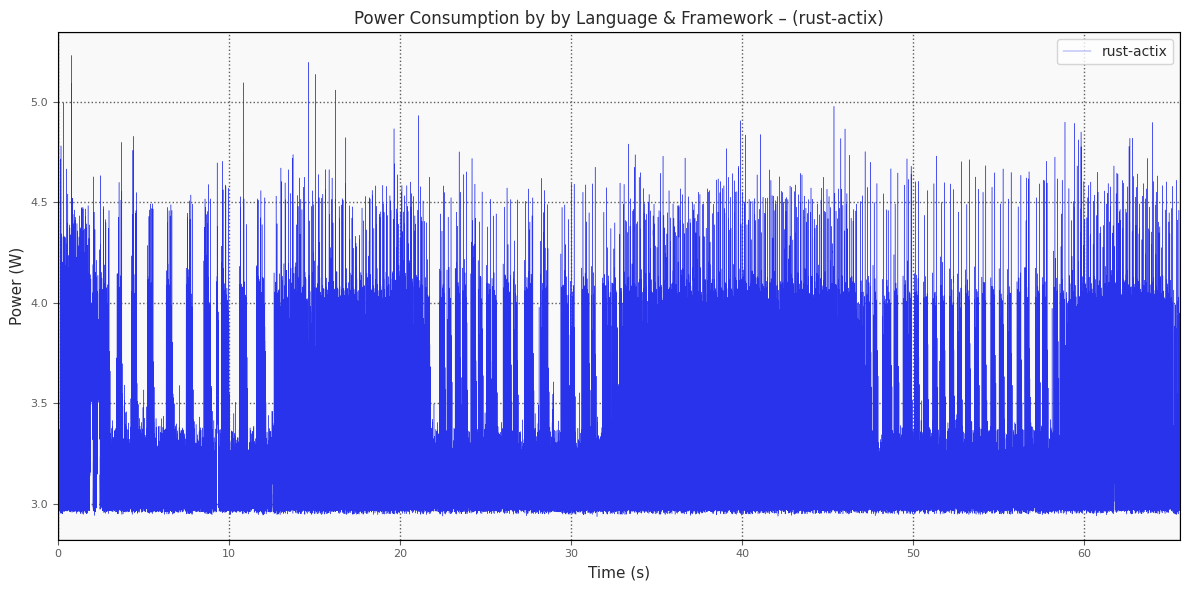

In [6]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

waect_service = 'rust-actix' # define service to be ploted
metric = 'power' # define metric to be ploted `power` and `energy`
df = data_dict[waect_service]

# settings for this plot
labels_fontsize = 11
labels_fontcolor = "#2A2A2A"
title_fontsize = 12
tick_color = "#5D5D5D"

# Plot single run power consumption
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
fig.patch.set_facecolor('#FFFFFF') 
ax.set_facecolor('#F9F9F9')

ax.plot(
    df.index,
    df[metric],
    linewidth=0.3,
    color='#2933EB'
)

# only if cumulative energy is polotted
if metric == 'cumulative_energy':
    ax.fill_between(
        df.index,
        df[metric],
        color='#2933EB',
        alpha=0.3 
    )
    
# Set title and labels
title, x_label, y_label = define_title_xlable_ylable_line_chart(metric)

ax.grid(True, linestyle='dotted', linewidth=1, color=tick_color)  # Setting custom grid color
ax.set_title(f'{title} – ({waect_service})', color=labels_fontcolor, fontsize=title_fontsize)  # Set an appropriate title
ax.set_xlabel(f"{x_label}", color=labels_fontcolor, fontsize=labels_fontsize,)  # Set an appropriate label for the x-axis
ax.set_ylabel(f"{y_label}", color=labels_fontcolor, fontsize=labels_fontsize)  # Label for the y-axis
ax.tick_params(labelsize=8, color=tick_color, labelcolor=tick_color)
ax.autoscale(enable=True, axis="x", tight=True)

border = Rectangle(
    (0, 0), 1, 1,
    transform=ax.transAxes,
    facecolor='none',
    edgecolor=tick_color,
    linewidth=1.0  
)

ax.add_patch(border)
    
ax.legend([waect_service], loc='upper right', fontsize=10, labelcolor=labels_fontcolor,facecolor="white", framealpha=0.8)
plt.tight_layout()
plt.show()

In [123]:
# Save the plot
save_plot(fig, waect_service, "berries", metric)

Plot for python-flask (berries) saved as cumulative_energy at plots/python-flask/berries


---
### Line Chart: Power Consumption Over Time for two applications runs

In [9]:
# Define services to compare
services = ['rust-actix', 'go-gorilla', 'python-flask']  # Define services to compare

# Determine the union of all timedelta_index values across the services
all_timedelta_indices = set()
for service in services:
    all_timedelta_indices.update(data_dict[service].index)

# Create a sorted list of all unique indices
all_timedelta_indices = sorted(all_timedelta_indices)

# Reindex each DataFrame to match the union of all timedelta_index values
for service in services:
    data_dict[service] = data_dict[service].reindex(all_timedelta_indices)

# Check the lengths of the DataFrames to confirm they are now the same
for service in services:
    print(f"{service} length: {len(data_dict[service])}")
    

rust-actix length: 3280550
go-gorilla length: 3280550
python-flask length: 3280550


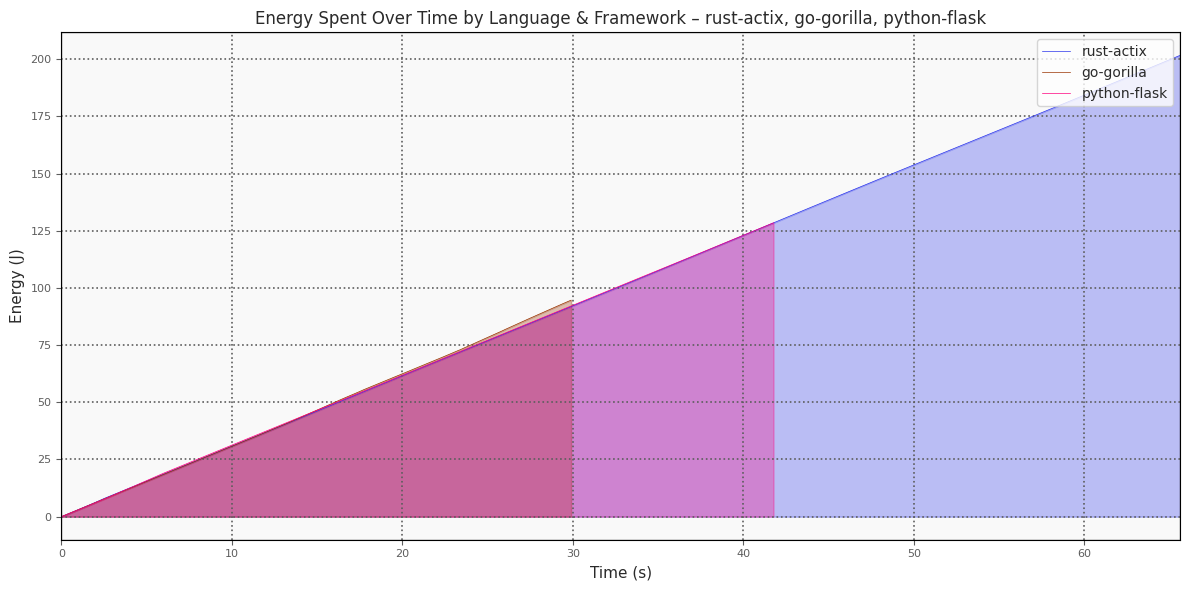

In [10]:
metric = 'cumulative_energy'  # Define the metric to compare - possible: 'power' & 'cumulative_energy'

# Plot cumulative energy consumption for both services
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
fig.patch.set_facecolor('#FFFFFF')
ax.set_facecolor('#F9F9F9')

# Define colors for each service
colors = ['#2933EB', '#993200', '#FF007E']  # Blue for python-flask, Brown for go-gorilla
alphas = [0.3, 0.3, 0.3, 0.3]  # Transparency for filled areas

# determine line alpha based on metric
if metric == 'power':
    line_alpha = 0.65
else:  
    line_alpha = 1.0

# Plotting cumulative energy with fill_between
for i, service in enumerate(services):
    ax.plot(
        data_dict[service].index,
        data_dict[service][metric],
        linewidth=0.5,
        color=colors[i],
        label=service,
        alpha=line_alpha
    )
    if metric == 'cumulative_energy':
        ax.fill_between(
            data_dict[service].index,
            data_dict[service][metric],
            color=colors[i],
            alpha=alphas[i]
        )
        
# Customize grid, labels, etc.
ax.grid(True, linestyle='dotted', linewidth=1.2, color=tick_color)
title, x_label, y_label = define_title_xlable_ylable_line_chart(metric)
ax.set_title(f'{title} – {", ".join(services)}', color=labels_fontcolor, fontsize=title_fontsize)
ax.set_xlabel(f"{x_label}", color=labels_fontcolor, fontsize=labels_fontsize)
ax.set_ylabel(f"{y_label}", color=labels_fontcolor, fontsize=labels_fontsize)
ax.tick_params(labelsize=8, color=tick_color, labelcolor=tick_color)
ax.autoscale(enable=True, axis="x", tight=True)

# Adding a border around the plot area (axes)
border = Rectangle(
    (0, 0), 1, 1,
    transform=ax.transAxes,
    facecolor='none',
    edgecolor=tick_color,
    linewidth=1
)
ax.add_patch(border)

# Add legend to distinguish between the services
ax.legend(loc='upper right', fontsize=10, labelcolor=labels_fontcolor, facecolor="white", framealpha=0.8)

plt.tight_layout()
plt.show()

In [140]:
# Save the plot
save_plot(fig, f'{"_".join(services)}_line_chart', plot_type="compare-berries", filename_suffix=metric)

Plot for go-gorilla_python-flask_line (compare-berries) saved as power at plots/compare-berries


---
### Boxplot: Boxplot for Power Consumption Comparison Across Applications

* plots a boxplot for power consumption comparison across applications.
* Define the services to compare 
* Define the metric to analyse `power`, `delta`, `energy`

/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_17652/2672155191.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


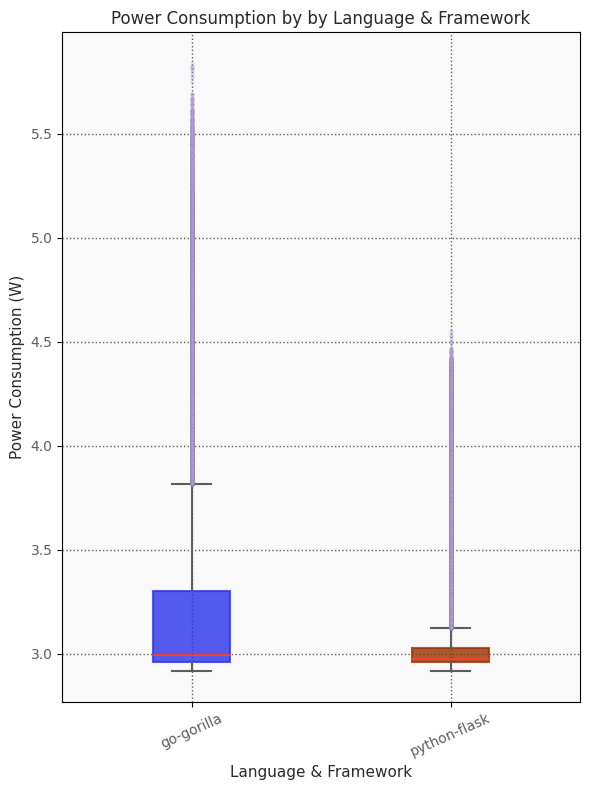

In [136]:
# Define services and endpoints
services = ['go-gorilla', 'python-flask']  # Define services to compare
metric = 'power'  # Define the metric to compare - possible power, delta, energy

# Prepare data for plotting
grouped_data = []
labels = []
group_colors = ['#2933EB', '#993200']  # Colors for the services (blue, green) currently
median_color = "#EB4532"
legend_labels = services 

for service in services:
    # grouping 
    df_service = data_dict[service]
    service_metric_data = df_service[metric].dropna() 
    grouped_data.append(service_metric_data)
    labels.append(service)

# Plotting
fig, ax = plt.subplots(figsize=(6, 8), facecolor='white')
ax.set_facecolor('#F9F9F9')

# Box plot
bplot = ax.boxplot(
    grouped_data,
    patch_artist=True,
    widths=0.3,
    labels=labels,
    flierprops=flierprops
)

for i, patch in enumerate(bplot['boxes']):
    patch.set(facecolor=group_colors[i % 2], alpha=0.8)  # Alternate colors for services
    patch.set(color=group_colors[i % 2], linewidth=1.5)
    patch.set(linewidth=1.5)  # Set border width
    
customize_boxplot(bplot, group_colors, tick_color, median_color)

# Set title and labels
title, x_label, y_label = define_title_xlable_ylable_boxplot(metric)
ax.set_title(f'{title}', color=labels_fontcolor, fontsize=title_fontsize)
ax.set_ylabel(f'{y_label}', color=labels_fontcolor, fontsize=labels_fontsize)
ax.set_xlabel(f'{x_label}', color=labels_fontcolor, fontsize=labels_fontsize)

# Customize tick labels
ax.tick_params(axis='x', labelsize=10, rotation=24, labelcolor='#5D5D5D')
ax.tick_params(axis='y', labelsize=10, labelcolor='#5D5D5D')
ax.grid(True, linestyle='dotted', linewidth=1.0, color=tick_color)

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.8) for color in group_colors]
# ax.legend(handles, legend_labels, loc='upper right', fontsize=10)

# Optional set y-axis limits for better visualization
# ax.set_ylim(0.3, 2.0)

# Show the plot
plt.tight_layout()
plt.show()


In [138]:
# save the plot
save_plot(fig, f'{"_".join(services)}_boxplot', plot_type="compare-berries", filename_suffix=metric)

Plot for go-gorilla_python-flask_boxplot (compare-berries) saved as power at plots/compare-berries
